In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image

In [2]:
base_skin_dir = os.path.join('./dataset')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, 'trainx/*.bmp'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Nevus',
    'mel': 'Melanoma'
}

In [3]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'PH2.csv'))


# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [4]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,image_id,dx,path,cell_type,cell_type_idx
0,IMD002,nv,./dataset/trainx/IMD002.bmp,Nevus,1
1,IMD003,nv,./dataset/trainx/IMD003.bmp,Nevus,1
2,IMD004,nv,./dataset/trainx/IMD004.bmp,Nevus,1
3,IMD006,nv,./dataset/trainx/IMD006.bmp,Nevus,1
4,IMD008,nv,./dataset/trainx/IMD008.bmp,Nevus,1


In [5]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [6]:
skin_df.head()

,image_id,dx,path,cell_type,cell_type_idx,image
0,IMD002,nv,./dataset/trainx/IMD002.bmp,Nevus,1,"[[[59, 55, 48], [58, 53, 47], [57, 53, 46], [5..."
1,IMD003,nv,./dataset/trainx/IMD003.bmp,Nevus,1,"[[[44, 40, 36], [45, 40, 39], [46, 40, 40], [4..."
2,IMD004,nv,./dataset/trainx/IMD004.bmp,Nevus,1,"[[[65, 60, 54], [62, 57, 54], [63, 59, 53], [6..."
3,IMD006,nv,./dataset/trainx/IMD006.bmp,Nevus,1,"[[[57, 47, 48], [59, 46, 51], [59, 46, 52], [5..."
4,IMD008,nv,./dataset/trainx/IMD008.bmp,Nevus,1,"[[[62, 56, 56], [64, 54, 57], [62, 54, 55], [6..."


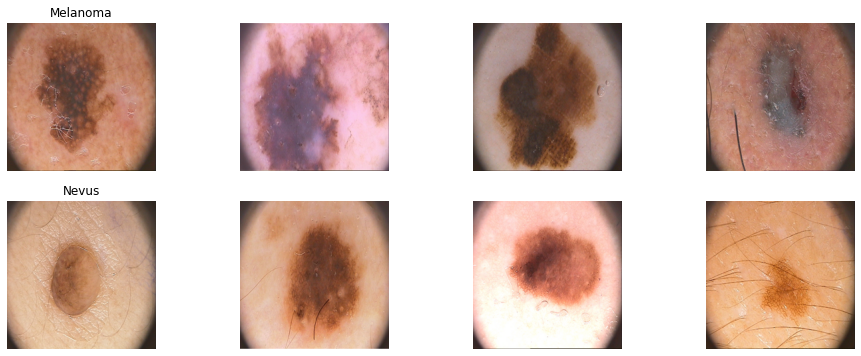

In [7]:
n_samples = 4
fig, m_axs = plt.subplots(2, n_samples, figsize = (4*n_samples, 3*2))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
#fig.savefig('category_samples.png', dpi=300)

In [8]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    200
Name: image, dtype: int64

In [9]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']
features.shape

(200, 5)

In [10]:
from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.3, random_state=42)
x_train_o.shape, x_test_o.shape

((140, 5), (60, 5))

In [11]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [12]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

In [13]:
# Reshape image in 3 dimensions (height = 224px, width = 224px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))

# Pre-trained model as a feature extractor

In [14]:
import keras, tensorflow
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import layers 
import numpy as np

# load pre-trained model
base_model = MobileNet(weights='imagenet')
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [15]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('global_average_pooling2d').output)

In [16]:
train_features = model.predict(x_train)
print(train_features.shape)

test_features = model.predict(x_test)
print(test_features.shape)

(140, 1024)
(60, 1024)


In [17]:
# visulize CNN layers 

"""model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv_pw_13_relu').output)
tfeatures = model.predict(x_test)


from matplotlib import pyplot

# Plot all 1024 maps in an 32x32 squares
square = 32
ix = 1
for _ in range(square):
    for _ in range(square):
    # Specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # Plot filter channel in grayscale
        pyplot.imshow(tfeatures[2, :, :, ix-1], cmap='viridis', aspect='auto')
        ix += 1
# how the figure
pyplot.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace=0, wspace=0)
pyplot.show()
"""

"model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv_pw_13_relu').output)\ntfeatures = model.predict(x_test)\n\n\nfrom matplotlib import pyplot\n\n# Plot all 1024 maps in an 32x32 squares\nsquare = 32\nix = 1\nfor _ in range(square):\n    for _ in range(square):\n    # Specify subplot and turn of axis\n        ax = pyplot.subplot(square, square, ix)\n        ax.set_xticks([])\n        ax.set_yticks([])\n        # Plot filter channel in grayscale\n        pyplot.imshow(tfeatures[2, :, :, ix-1], cmap='viridis', aspect='auto')\n        ix += 1\n# how the figure\npyplot.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace=0, wspace=0)\npyplot.show()\n"

In [18]:
import itertools

# Function to plot confusion matrix for validation image   
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Logistic Regression

CLASSIFICATION REPORT FOR Logistic Regression
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.92      0.96      0.94        48

    accuracy                           0.90        60
   macro avg       0.86      0.81      0.83        60
weighted avg       0.90      0.90      0.90        60

train score: 1.0
test_score 0.9


,0,1,micro-average
accuracy,0.900000,0.900000,0.9
precision,0.800000,0.920000,0.9
recall,0.666667,0.958333,0.9
specificity,0.958333,0.666667,0.9
f1,0.727273,0.938776,0.9


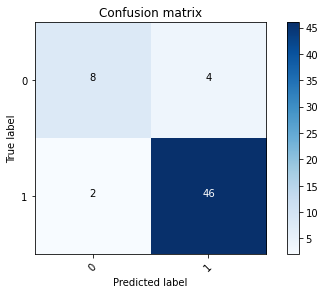

In [19]:
from sklearn.metrics import confusion_matrix,classification_report
# Import module for fitting
from sklearn.linear_model import LogisticRegression
# Create instance (i.e. object) of LogisticRegression
Lr_model = LogisticRegression(max_iter=1000, C=1 ,random_state = 0)

Lr_model.fit(train_features, y_train_o)

trainscore = Lr_model.score(train_features, y_train_o)
testscore = Lr_model.score(test_features, y_test_o)

test_predictions = Lr_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Logistic Regression")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = range(2)) 
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Lr_model, train_features, y_train_o, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print()
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())

#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# SVM

CLASSIFICATION REPORT FOR SVM Linear
Confusion MAtrix:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        12
           1       0.88      0.94      0.91        48

    accuracy                           0.85        60
   macro avg       0.77      0.72      0.74        60
weighted avg       0.84      0.85      0.84        60

train score: 1.0
test_score 0.85


,0,1,micro-average
accuracy,0.850000,0.850000,0.85
precision,0.666667,0.882353,0.85
recall,0.500000,0.937500,0.85
specificity,0.937500,0.500000,0.85
f1,0.571429,0.909091,0.85


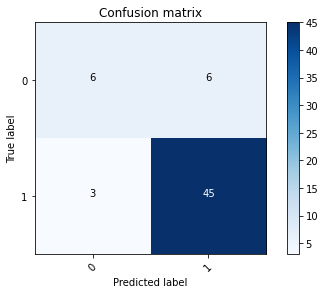

In [20]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1, random_state=0).fit(train_features, y_train_o)

trainscore = svm_model.score(train_features, y_train_o)
testscore = svm_model.score(test_features, y_test_o)

test_predictions = svm_model.predict(test_features)

print("CLASSIFICATION REPORT FOR SVM Linear")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = range(2)) 
#print(cm)
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(svm_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print()
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())

#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])


# SVM Redial Kernal

CLASSIFICATION REPORT FOR SVM Redial Kernal
Confusion MAtrix:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        12
           1       0.89      1.00      0.94        48

    accuracy                           0.90        60
   macro avg       0.94      0.75      0.80        60
weighted avg       0.91      0.90      0.89        60

train score: 1.0
test_score 0.9


,0,1,micro-average
accuracy,0.900000,0.900000,0.9
precision,1.000000,0.888889,0.9
recall,0.500000,1.000000,0.9
specificity,1.000000,0.500000,0.9
f1,0.666667,0.941176,0.9


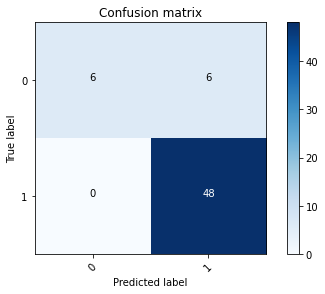

In [21]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', C=3, gamma='scale').fit(train_features, y_train_o)

trainscore = svm_model.score(train_features, y_train_o)
testscore = svm_model.score(test_features, y_test_o)

test_predictions = svm_model.predict(test_features)

print("CLASSIFICATION REPORT FOR SVM Redial Kernal")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = range(2)) 
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)

# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(svm_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])


# Naive Bayes

CLASSIFICATION REPORT FOR Naive Bayes
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.90      0.92      0.91        48

    accuracy                           0.85        60
   macro avg       0.77      0.75      0.76        60
weighted avg       0.85      0.85      0.85        60

train score: 0.9642857142857143
test_score 0.85


,0,1,micro-average
accuracy,0.850000,0.850000,0.85
precision,0.636364,0.897959,0.85
recall,0.583333,0.916667,0.85
specificity,0.916667,0.583333,0.85
f1,0.608696,0.907216,0.85


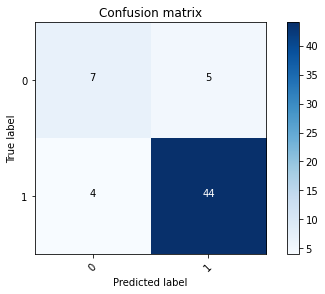

In [22]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
nb_model = GaussianNB()

# Train the model using the training sets
nb_model.fit(train_features,  y_train_o)

trainscore = nb_model.score(train_features,  y_train_o)
testscore = nb_model.score(test_features,  y_test_o)

test_predictions = nb_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Naive Bayes")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = range(2)) 
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(nb_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())

#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# Ada Boost

CLASSIFICATION REPORT FOR Ada Boost
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.90      0.98      0.94        48

    accuracy                           0.90        60
   macro avg       0.89      0.78      0.82        60
weighted avg       0.90      0.90      0.89        60

train score: 1.0
test_score 0.9


,0,1,micro-average
accuracy,0.900000,0.900000,0.9
precision,0.875000,0.903846,0.9
recall,0.583333,0.979167,0.9
specificity,0.979167,0.583333,0.9
f1,0.700000,0.940000,0.9


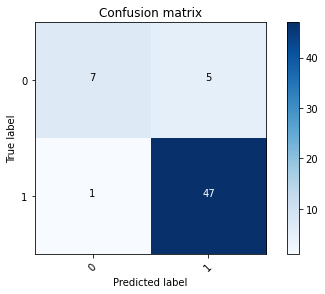

In [23]:
from sklearn.ensemble import AdaBoostClassifier
# Create adaboost classifer object
classifier = AdaBoostClassifier()
# Train Adaboost Classifer
Ab_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Ab_model.score(train_features, y_train_o)
testscore = Ab_model.score(test_features, y_test_o)

test_predictions = Ab_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Ada Boost")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = range(2))
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Ab_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())

#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])


# Random Forest

CLASSIFICATION REPORT FOR Random Forest
Confusion MAtrix:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        12
           1       0.89      1.00      0.94        48

    accuracy                           0.90        60
   macro avg       0.94      0.75      0.80        60
weighted avg       0.91      0.90      0.89        60

train score: 1.0
test_score 0.9


,0,1,micro-average
accuracy,0.900000,0.900000,0.9
precision,1.000000,0.888889,0.9
recall,0.500000,1.000000,0.9
specificity,1.000000,0.500000,0.9
f1,0.666667,0.941176,0.9


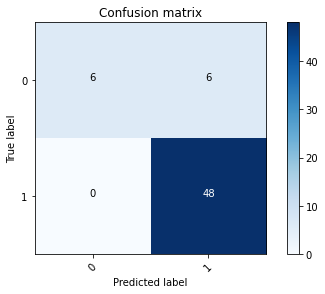

In [24]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()

#Train the model using the training sets 
Rf_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Rf_model.score(train_features, y_train_o)
testscore = Rf_model.score(test_features, y_test_o)

test_predictions = Rf_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Random Forest")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = range(2))
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Rf_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# linear discriminant analysis

CLASSIFICATION REPORT FOR Linear Discriminant Analysis
Confusion MAtrix:

              precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.91      1.00      0.95        48

    accuracy                           0.92        60
   macro avg       0.95      0.79      0.84        60
weighted avg       0.92      0.92      0.91        60

train score: 0.9428571428571428
test_score 0.9166666666666666


,0,1,micro-average
accuracy,0.916667,0.916667,0.916667
precision,1.000000,0.905660,0.916667
recall,0.583333,1.000000,0.916667
specificity,1.000000,0.583333,0.916667
f1,0.736842,0.950495,0.916667


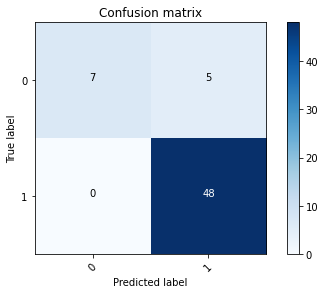

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

classifier = LinearDiscriminantAnalysis()

#Train the model using the training sets 
Lda_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Lda_model.score(train_features, y_train_o)
testscore = Lda_model.score(test_features, y_test_o)

test_predictions = Lda_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Linear Discriminant Analysis")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = range(2))
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Lda_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# K Nearest Neighbor

CLASSIFICATION REPORT FOR K Nearest Neighbor
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.90      0.98      0.94        48

    accuracy                           0.90        60
   macro avg       0.89      0.78      0.82        60
weighted avg       0.90      0.90      0.89        60

train score: 0.9357142857142857
test_score 0.9


,0,1,micro-average
accuracy,0.900000,0.900000,0.9
precision,0.875000,0.903846,0.9
recall,0.583333,0.979167,0.9
specificity,0.979167,0.583333,0.9
f1,0.700000,0.940000,0.9


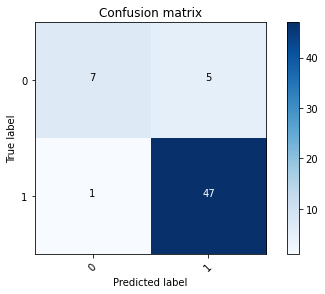

In [26]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()

#Train the model using the training sets 
Lda_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Lda_model.score(train_features, y_train_o)
testscore = Lda_model.score(test_features, y_test_o)

test_predictions = Lda_model.predict(test_features)

print("CLASSIFICATION REPORT FOR K Nearest Neighbor")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = range(2))
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Lda_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# Neural Network

CLASSIFICATION REPORT FOR Neural Network
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.92      0.98      0.95        48

    accuracy                           0.92        60
   macro avg       0.91      0.82      0.86        60
weighted avg       0.92      0.92      0.91        60

train score: 1.0
test_score 0.9166666666666666


,0,1,micro-average
accuracy,0.916667,0.916667,0.916667
precision,0.888889,0.921569,0.916667
recall,0.666667,0.979167,0.916667
specificity,0.979167,0.666667,0.916667
f1,0.761905,0.949495,0.916667


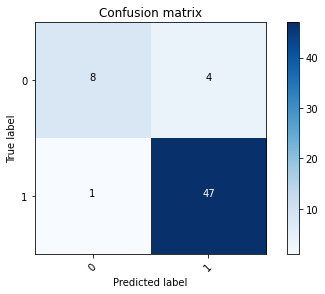

In [27]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()

#Train the model using the training sets 
Lda_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Lda_model.score(train_features, y_train_o)
testscore = Lda_model.score(test_features, y_test_o)

test_predictions = Lda_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Neural Network")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = range(2))
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Lda_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# Decision Tree

CLASSIFICATION REPORT FOR Decision Tree
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.47      0.58      0.52        12
           1       0.89      0.83      0.86        48

    accuracy                           0.78        60
   macro avg       0.68      0.71      0.69        60
weighted avg       0.80      0.78      0.79        60

train score: 1.0
test_score 0.7833333333333333


,0,1,micro-average
accuracy,0.783333,0.783333,0.783333
precision,0.466667,0.888889,0.783333
recall,0.583333,0.833333,0.783333
specificity,0.833333,0.583333,0.783333
f1,0.518519,0.860215,0.783333


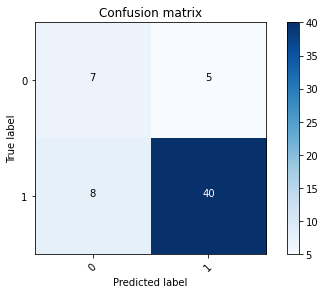

In [28]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()

#Train the model using the training sets 
Lda_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Lda_model.score(train_features, y_train_o)
testscore = Lda_model.score(test_features, y_test_o)

test_predictions = Lda_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Decision Tree")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = range(2))
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Lda_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])